In [29]:
from urllib.parse import quote_plus
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv
import pandas as pd

# Check if .env.local exists before loading
if not os.path.exists(".env.local"):
    raise FileNotFoundError("The .env.local file was not found. Please check it in.")

# Load environment variables from .env.local and override any existing ones
load_dotenv(".env.local", override=True)

# Check that all required environment variables are set
required_vars = [
    "AACT_HOST",
    "AACT_PORT",
    "AACT_DB",
    "AACT_USER",
    "AACT_PASS"
]
missing = [k for k in required_vars if os.environ.get(k) is None]
if missing:
    raise EnvironmentError(f"Missing required environment variables in .env.local: {', '.join(missing)}. Please check them in.")

url = (
    f"postgresql+psycopg2://{os.environ['AACT_USER']}:"
    f"{quote_plus(os.environ['AACT_PASS'])}@"
    f"{os.environ['AACT_HOST']}:{os.environ['AACT_PORT']}/"
    f"{os.environ['AACT_DB']}"
)

engine = create_engine(url, connect_args={"sslmode": "require"})
with engine.connect() as con:
    tables = pd.read_sql(
        """
        SELECT table_name
        FROM information_schema.tables
        WHERE table_schema='ctgov'
          AND table_name IN ('studies',
                             'facilities',
                             'facility_investigators',
                             'overall_officials')
        """,
        con,
    )
print(tables)


               table_name
0              facilities
1  facility_investigators
2       overall_officials
3                 studies


In [30]:
from sqlalchemy import text
import pandas as pd

def sanity_check_investigator_sample(limit: int = 20, conn = engine) -> pd.DataFrame:
    """
    Pull a small sample of investigator–facility pairs from the US so we can
    verify that the AACT connection, permissions, and table names are correct.

    Parameters
    ----------
    limit : int, default 20
        How many rows to fetch.
    conn  : SQLAlchemy Engine/Connection, default `engine`
        The AACT connection to use.

    Returns
    -------
    pd.DataFrame
        Investigator name, role, and basic facility metadata.
    """
    sql = text("""
        SELECT  fi.name        AS investigator,
                fi.role        AS role,
                f.name         AS facility,
                f.city,
                f.state,
                f.zip,
                f.nct_id
        FROM    ctgov.facility_investigators fi
        JOIN    ctgov.facilities            f  ON f.id = fi.facility_id
        WHERE   f.country = 'United States'
        LIMIT   :row_limit;
    """)

    with conn.begin() as c:
        df = pd.read_sql(sql, c, params={"row_limit": limit})

    print(f"✓  Retrieved {len(df)} investigator rows.")
    return df

# ── run the check ───────────────────────────────────────────────────────────
df_test = sanity_check_investigator_sample(20)
display(df_test)


✓  Retrieved 20 investigator rows.


,investigator,role,facility,city,state,zip,nct_id
0,"Joseph Pidala, MD, PhD",PRINCIPAL_INVESTIGATOR,Moffitt Cancer Center,Tampa,Florida,33612,NCT05996627
1,"Kent Hutchison, PhD",PRINCIPAL_INVESTIGATOR,University of Colorado Denver,Aurora,Colorado,80045,NCT05299944
2,"Chaitali Nangia, MD",PRINCIPAL_INVESTIGATOR,Chan Soon-Shiong Institute for Medicine,El Segundo,California,90245,NCT04898543
3,"Mee Young Hong, PhD",PRINCIPAL_INVESTIGATOR,San Diego State University,San Diego,California,92182,NCT05279729
4,"Robert J Castro, BS",PRINCIPAL_INVESTIGATOR,San Diego State University,San Diego,California,92182,NCT05279729
5,Benjamin M. Ellingson,PRINCIPAL_INVESTIGATOR,UCLA / Jonsson Comprehensive Cancer Center,Los Angeles,California,90095,NCT06090903
6,"Zachariah DeFilipp, MD",PRINCIPAL_INVESTIGATOR,Mass General Cancer Center,Boston,Massachusetts,02114,NCT05996627
7,"Sarah R. Dubowsky, Ph.D.",PRINCIPAL_INVESTIGATOR,Kessler Medical Rehabilitation Research and Ed...,West Orange,New Jersey,07052,NCT00785278
8,"Gail F. Forrest, Ph.D.",SUB_INVESTIGATOR,Kessler Medical Rehabilitation Research and Ed...,West Orange,New Jersey,07052,NCT00785278
9,"Trevor A. Dyson-Hudson, M.D.",SUB_INVESTIGATOR,Kessler Medical Rehabilitation Research and Ed...,West Orange,New Jersey,07052,NCT00785278


In [31]:
from sqlalchemy import text
import pandas as pd

def investigators_by_zip(zip_code_prefix: str,
                         conn = engine) -> pd.DataFrame:
    """
    Return all named investigators (PI, Sub‑I, Study Chairs, etc.)
    whose facilities have a U.S. ZIP code that starts with `zip_code_prefix`.

    Parameters
    ----------
    zip_code_prefix : str
        The leading part of the ZIP code.  Examples:
          • "94110"  –– exactly 94110 and 94110‑####
          • "100"    –– any ZIP in 100** (Manhattan)
    conn : SQLAlchemy Engine or Connection, default `engine`
        The AACT connection to use.

    Returns
    -------
    pd.DataFrame
        One row per investigator‑facility‑study combination.
    """
    sql = text("""
        SELECT
            fi.name           AS investigator,
            fi.role           AS role,
            f.name            AS facility,
            f.city,
            f.state,
            f.zip,
            f.nct_id,
            s.brief_title,
            s.phase
        FROM   ctgov.facilities             f
        JOIN   ctgov.facility_investigators fi
               ON fi.facility_id = f.id
        JOIN   ctgov.studies               s
               ON s.nct_id = f.nct_id
        WHERE  f.country = 'United States'
          AND  f.zip LIKE :zip_prefix
        ORDER  BY fi.name;
    """)

    with conn.begin() as c:                       # keeps the same engine
        return pd.read_sql(sql,
                           c,
                           params={"zip_prefix": f"{zip_code_prefix}%"})

# ── example usage ──────────────────────────────────────────────────────────
df = investigators_by_zip("07052")   # West Orange, NJ
display(df.head())                   # or simply print(df) in a script


,investigator,role,facility,city,state,zip,nct_id,brief_title,phase
0,"Alice Hon, M.D.",SUB_INVESTIGATOR,Kessler Institute for Rehabilitation,West Orange,New Jersey,07052,NCT02127606,The Effect of Whole Body Vibration on Spastici...,NA
1,"Andrew M. Kwarciak, M.S.",SUB_INVESTIGATOR,Kessler Medical Rehabilitation Research and Ed...,West Orange,New Jersey,07052,NCT00785278,Adjusting Wheelchair Set-Up to Minimize Should...,None
2,"Arvind Ramanujam, M.S.",SUB_INVESTIGATOR,Kessler Medical Rehabilitation Research and Ed...,West Orange,New Jersey,07052,NCT00785278,Adjusting Wheelchair Set-Up to Minimize Should...,None
3,"Brittany Snider, DO",SUB_INVESTIGATOR,Kessler Foundation,West Orange,New Jersey,07052,NCT05731986,Spinal Cord Transcutaneous Stimulation Effect ...,NA
4,"Brittany Snider, MD",SUB_INVESTIGATOR,Kessler Foundation,West Orange,New Jersey,07052,NCT05432999,Extracorporeal Shockwave Therapy for Spasticit...,NA


In [32]:
from sqlalchemy import text
import pandas as pd

def investigators_by_zip_since(zip_code_prefix: str,
                               start_date_cutoff: str,
                               recruiting_only: bool = False,
                               conn = engine) -> pd.DataFrame:
    """
    Investigators at US facilities whose ZIP starts with `zip_code_prefix`
    AND whose study start_date >= `start_date_cutoff` (YYYY‑MM‑DD).

    Parameters
    ----------
    zip_code_prefix    : str   –– e.g. "07052"  or "100"
    start_date_cutoff  : str   –– ISO date "YYYY-MM-DD"
    recruiting_only    : bool  –– keep only Recruiting / Not‑yet recruiting
    """
    sql = text("""
        SELECT
            fi.name      AS investigator,
            fi.role      AS role,
            f.name       AS facility,
            f.city, f.state, f.zip,
            s.start_date,
            s.nct_id, s.brief_title
        FROM   ctgov.facilities             f
        JOIN   ctgov.facility_investigators fi ON fi.facility_id = f.id
        JOIN   ctgov.studies               s  ON s.nct_id = f.nct_id
        WHERE  f.country       = 'United States'
          AND  f.zip           LIKE :zip_prefix
          AND  s.start_date   >= :cutoff_date
          {status_clause}
        ORDER  BY fi.name;
    """.format(
        status_clause = ("AND f.status IN ('Recruiting','Not yet recruiting')"
                         if recruiting_only else "")
    ))

    with conn.begin() as c:
        return pd.read_sql(sql, c,
                           params={"zip_prefix": f"{zip_code_prefix}%",
                                   "cutoff_date": start_date_cutoff})
    
df_recent = investigators_by_zip_since("94110", "2020-01-01")
display(df_recent)

,investigator,role,facility,city,state,zip,start_date,nct_id,brief_title
0,"Anjana Sharma, MD",SUB_INVESTIGATOR,Zuckerberg San Francisco General Hospital (ZSF...,San Francisco,California,94110,2024-11-04,NCT06598436,Achieving Chronic Care equiTy by leVeraging th...
1,"Benjamin Breyer, MD",PRINCIPAL_INVESTIGATOR,University of California San Francisco,San Francisco,California,94110,2025-07-31,NCT03258658,Safety and Feasibility Study of Autologous Eng...
2,"Cathra Halabi, MD",PRINCIPAL_INVESTIGATOR,San Francisco General Hospital,San Francisco,California,94110,2022-06-18,NCT05338697,Validation of Early Prognostic Data for Recove...
3,Chia-Ching (Jackie) Wang,PRINCIPAL_INVESTIGATOR,Zuckerberg San Francisco General Hospital,San Francisco,California,94110,2022-08-09,NCT04929028,Therapy Adapted for High Risk and Low Risk HIV...
4,"Delphine Tuot, MD MAS",PRINCIPAL_INVESTIGATOR,Zuckerberg San Francisco General Hospital (ZSF...,San Francisco,California,94110,2024-11-04,NCT06598436,Achieving Chronic Care equiTy by leVeraging th...
5,"Elaine Khoong, MD, MS",PRINCIPAL_INVESTIGATOR,Zuckerberg San Francisco Hospital,San Francisco,California,94110,2025-04-01,NCT06871462,Implementation Strategies for Self-Measured Bl...
6,"Geoffrey Manley, MD, PhD",PRINCIPAL_INVESTIGATOR,"University of California, San Francisco",San Francisco,California,94110,2025-04-30,NCT06790095,TRACK-TBI Precision Medicine Part 3 - Option II
7,"Gideon St. Helen, PhD",PRINCIPAL_INVESTIGATOR,Zuckerberg San Francisco General Hospital,San Francisco,California,94110,2025-05-01,NCT05999383,Understanding the Clinical Pharmacology of Mar...
8,"Harini Sarathy, MD",PRINCIPAL_INVESTIGATOR,UCSF/Zuckerberg San Francisco General Hospital...,San Francisco,California,94110,2024-11-13,NCT06243068,Expanding and Promoting Alternative Care and k...
9,"Henry F Vanbrocklin, PhD",SUB_INVESTIGATOR,"University of California, San Francisco",San Francisco,California,94110,2021-04-15,NCT04815096,Imaging Immune Activation in COVID-19


In [33]:
import math
from sqlalchemy import text
import pandas as pd

_MILES_PER_LAT = 69.0      # one degree latitude ≈ 69 mi

def _bounding_box(lat0: float, lon0: float, radius_miles: float):
    """Return (min_lat, max_lat, min_lon, max_lon)."""
    delta_lat = radius_miles / _MILES_PER_LAT
    delta_lon = radius_miles / (_MILES_PER_LAT * math.cos(math.radians(lat0)))
    return (lat0 - delta_lat, lat0 + delta_lat,
            lon0 - delta_lon, lon0 + delta_lon)

def investigators_within_radius(origin_zip: str,
                                radius_miles: float = 25,
                                start_date_cutoff: str | None = None,
                                statuses: list[str] | None = None,
                                conn = engine) -> pd.DataFrame:
    """
    Investigators at any US facility whose (lat,lon) lies within
    `radius_miles` of the first facility found for `origin_zip`.

    Parameters
    ----------
    origin_zip        : str    –– exact 5‑digit ZIP (e.g. "07052")
    radius_miles      : float  –– search radius
    start_date_cutoff : str | None –– optional "YYYY‑MM‑DD"
    statuses          : list[str] | None –– e.g. ['Recruiting','Completed']
    """
    # 1. get lat/lon for the origin ZIP
    ll_sql = text("""
        SELECT latitude, longitude
        FROM   ctgov.facilities
        WHERE  country = 'United States'
          AND  zip     = :zip_exact
          AND  latitude IS NOT NULL
        LIMIT  1;
    """)
    with conn.begin() as c:
        row = c.execute(ll_sql, {"zip_exact": origin_zip}).fetchone()
        if row is None:
            raise ValueError(f"No facility with exact ZIP {origin_zip} found")
        lat0, lon0 = map(float, row)

    # 2. bounding box limits
    min_lat, max_lat, min_lon, max_lon = _bounding_box(lat0, lon0, radius_miles)

    status_clause = ("AND f.status = ANY(:statuses)" if statuses else "")
    date_clause   = ("AND s.start_date >= :cutoff"   if start_date_cutoff else "")

    sql = text(f"""
        SELECT
            fi.name     AS investigator,
            fi.role,
            f.name      AS facility,
            f.city, f.state, f.zip,
            f.latitude, f.longitude,
            s.start_date,
            s.nct_id, s.brief_title
        FROM   ctgov.facilities             f
        JOIN   ctgov.facility_investigators fi ON fi.facility_id = f.id
        JOIN   ctgov.studies               s  ON s.nct_id = f.nct_id
        WHERE  f.country = 'United States'
          AND  f.latitude  BETWEEN :min_lat AND :max_lat
          AND  f.longitude BETWEEN :min_lon AND :max_lon
          {status_clause}
          {date_clause}
        ORDER  BY fi.name;
    """)

    params = {"min_lat": min_lat, "max_lat": max_lat,
              "min_lon": min_lon, "max_lon": max_lon}
    if statuses:
        params["statuses"] = statuses
    if start_date_cutoff:
        params["cutoff"] = start_date_cutoff

    with conn.begin() as c:
        return pd.read_sql(sql, c, params=params)


In [34]:
# All investigators within 25 mi of ZIP 07052, regardless of status or date
near_kessler = investigators_within_radius("07052", radius_miles=25)
print(len(near_kessler), "rows"); display(near_kessler.head())

# Only Recruiting facilities within 50 mi of 10016 that started since 2020‑01‑01
near_nyu = investigators_within_radius(
              "10016",
              radius_miles=50,
              start_date_cutoff="2020-01-01",
              statuses=["Recruiting","Not yet recruiting"])
print(len(near_nyu), "rows"); display(near_nyu.head())

3942 rows


,investigator,role,facility,city,state,zip,latitude,longitude,start_date,nct_id,brief_title
0,"Aakriti G Shukla, MD, MSc",PRINCIPAL_INVESTIGATOR,Columbia University Irving Medical Center,New York,New York,10032,40.71427,-74.00597,2024-12-12,NCT06636708,Efficacy of Nanodropper-mediated Topical Anest...
1,Aaron D. Goldberg,PRINCIPAL_INVESTIGATOR,Memorial Sloan Kettering Cancer Center,New York,New York,10065,40.71427,-74.00597,2024-09-27,NCT06317649,Venetoclax and HMA Treatment of Older and Unfi...
2,Aaron D. Goldberg,PRINCIPAL_INVESTIGATOR,Memorial Sloan Kettering Basking Ridge,Basking Ridge,New Jersey,07920,40.70621,-74.54932,2024-09-27,NCT06317649,Venetoclax and HMA Treatment of Older and Unfi...
3,Aaron D. Goldberg,PRINCIPAL_INVESTIGATOR,Memorial Sloan Kettering Basking Ridge,Basking Ridge,New Jersey,07920,40.70621,-74.54932,2024-06-18,NCT05564390,MYELOMATCH: A Screening Study to Assign People...
4,Aaron D. Goldberg,PRINCIPAL_INVESTIGATOR,Memorial Sloan Kettering Cancer Center,New York,New York,10065,40.71427,-74.00597,2024-06-18,NCT05564390,MYELOMATCH: A Screening Study to Assign People...


0 rows


,investigator,role,facility,city,state,zip,latitude,longitude,start_date,nct_id,brief_title


## Other API route

In [35]:
from __future__ import annotations
import pandas as pd
from sqlalchemy import text
from datetime import date, timedelta

In [36]:
def investigators_by_zip_and_years(zip_prefix: str,
                                   years_back: int = 5,
                                   roles: list[str] | None = None,
                                   conn = engine) -> pd.DataFrame:
    from datetime import date, timedelta
    cutoff = (date.today() - timedelta(days=365*years_back)).isoformat()

    # ------------------------------------------------------------------
    # role filter (empty string if no roles were supplied)
    # ------------------------------------------------------------------
    role_clause = ""
    params = {"zip_prefix": f"{zip_prefix}%", "cutoff": cutoff}

    if roles:
        role_clause = "WHERE lower(src.role) = ANY(:roles)"
        params["roles"] = [r.lower() for r in roles]
    # ------------------------------------------------------------------

    sql = text(f"""
        WITH target_studies AS (
            SELECT DISTINCT s.nct_id
            FROM   ctgov.studies   s
            JOIN   ctgov.facilities f
                   ON f.nct_id = s.nct_id
            WHERE  f.country = 'United States'
              AND  f.zip     LIKE :zip_prefix
              AND  s.start_date >= :cutoff
        ),

        site_inv AS (
            SELECT fi.name,
                   fi.role,
                   f.name   AS facility,
                   f.city, f.state, f.zip,
                   s.nct_id,
                   s.brief_title,
                   s.phase,
                   s.start_date,
                   'facility_investigators' AS src_tbl
            FROM   ctgov.facility_investigators fi
            JOIN   ctgov.facilities            f  ON f.id = fi.facility_id
            JOIN   ctgov.studies               s  ON s.nct_id = f.nct_id
            WHERE  s.nct_id IN (SELECT nct_id FROM target_studies)
        ),

        study_inv AS (
            SELECT oo.name,
                   oo.role,
                   NULL AS facility,
                   NULL AS city,
                   NULL AS state,
                   NULL AS zip,
                   s.nct_id,
                   s.brief_title,
                   s.phase,
                   s.start_date,
                   'overall_officials'        AS src_tbl
            FROM   ctgov.overall_officials oo
            JOIN   ctgov.studies          s ON s.nct_id = oo.nct_id
            WHERE  s.nct_id IN (SELECT nct_id FROM target_studies)
        )

        SELECT DISTINCT ON (lower(name), nct_id) *
        FROM (
              SELECT * FROM site_inv
              UNION ALL
              SELECT * FROM study_inv
             ) src
        {role_clause}                         -- <-- now has WHERE, not AND
        ORDER BY lower(name), nct_id;
    """)

    with conn.begin() as c:
        return pd.read_sql(sql, c, params=params)

In [37]:
df_test = investigators_by_zip_and_years("94110", years_back=10,
                                         roles=["Principal_Investigator",
                                                "Study_Chair"])
print(f"{len(df_test):,} rows")
df_test.head()

1,569 rows


,name,role,facility,city,state,zip,nct_id,brief_title,phase,start_date,src_tbl
0,"Aadia Rana, M.D.",STUDY_CHAIR,None,None,None,None,NCT03635788,The LATITUDE Study: Long-Acting Therapy to Imp...,PHASE3,2019-03-28,overall_officials
1,Aalok Kumar,PRINCIPAL_INVESTIGATOR,BC Cancer Surrey,Surrey,British Columbia,V3V 1Z2,NCT05514054,A Study of Imlunestrant Versus Standard Endocr...,PHASE3,2022-10-04,facility_investigators
2,Aaron S. Mansfield,PRINCIPAL_INVESTIGATOR,Mayo Clinic in Rochester,Rochester,Minnesota,55905,NCT04242095,Collection of Research Data and Samples From P...,None,2020-03-12,facility_investigators
3,Aart Beeker,PRINCIPAL_INVESTIGATOR,Spaarne Gasthuis - Hoofddorp,Hoofddorp,Noord-Holland,2134 TM,NCT05514054,A Study of Imlunestrant Versus Standard Endocr...,PHASE3,2022-10-04,facility_investigators
4,Abdul Hai Mansoor,PRINCIPAL_INVESTIGATOR,Kaiser Permanente Northwest,Portland,Oregon,97227,NCT05812807,Pembrolizumab vs. Observation in People With T...,PHASE3,2023-06-14,facility_investigators


In [38]:
def list_unique_investigators(df: pd.DataFrame) -> pd.Series:
    unique_names = (df["name"]
                    .dropna()
                    .sort_values(key=lambda s: s.str.lower())
                    .drop_duplicates()
                    .reset_index(drop=True))
    print(f"Number of unique investigators: {len(unique_names):,}")
    return unique_names

list_unique_investigators(df_test).head(20)

Number of unique investigators: 1,387


0             Aadia Rana, M.D.
1                  Aalok Kumar
2           Aaron S. Mansfield
3                  Aart Beeker
4            Abdul Hai Mansoor
5               Abhigna Kodali
6               Abhishek Joshi
7              Abiola Ibraheem
8        Abirami Sivapiragasam
9             Achala Vagal, MD
10              Adam M. Forman
11              Adam W. Nowlan
12             Adnan Alkhalili
13        Adrian Aguilera, PhD
14                Adrian Nervo
15    Adriana Andrade, MD, MPH
16             Ahmed A. Khalid
17             Ahmed Elkhanany
18           Ahmet Alacacioglu
19                Ahmet Bilici
Name: name, dtype: object

In [39]:
from datetime import date, timedelta
from sqlalchemy import text
import pandas as pd

def raw_investigator_dump(years_back: int = 10, conn=engine) -> pd.DataFrame:
    """
    One row per investigator–study combination, last N years.
    For site‑level investigators we keep the actual facility ZIP;
    for study‑level we keep affiliation text (ZIP will be filled later).
    """
    cutoff = (date.today() - timedelta(days=365 * years_back)).isoformat()

    sql = text("""
        WITH site_inv AS (
            SELECT fi.name,
                   fi.role,
                   f.name           AS facility,
                   f.city, f.state, f.zip,                      -- has ZIP
                   NULL             AS affiliation,
                   s.nct_id, s.start_date
            FROM   ctgov.facility_investigators fi
            JOIN   ctgov.facilities            f  ON f.id = fi.facility_id
            JOIN   ctgov.studies               s  ON s.nct_id = f.nct_id
            WHERE  s.start_date >= :cutoff
              AND  f.country   = 'United States'
        ),
        study_inv AS (
            SELECT oo.name,
                   oo.role,
                   NULL              AS facility,
                   NULL AS city, NULL AS state, NULL AS zip,     -- missing ZIP
                   oo.affiliation,
                   s.nct_id, s.start_date
            FROM   ctgov.overall_officials oo
            JOIN   ctgov.studies          s  ON s.nct_id = oo.nct_id
            WHERE  s.start_date >= :cutoff
        )

        SELECT *
        FROM (
              SELECT * FROM site_inv
              UNION ALL
              SELECT * FROM study_inv
             ) inv
        WHERE name IS NOT NULL;          -- safety
    """)

    with conn.begin() as c:
        return pd.read_sql(sql, c, params={"cutoff": cutoff})

raw_df = raw_investigator_dump(10)
raw_df.head()

,name,role,facility,city,state,zip,affiliation,nct_id,start_date
0,Dennis F. Moore,PRINCIPAL_INVESTIGATOR,Cancer Center of Kansas-Kingman,Kingman,Kansas,67068,None,NCT04379570,2021-02-15
1,Jeffrey A. Meyerhardt,PRINCIPAL_INVESTIGATOR,Dana-Farber Cancer Institute,Boston,Massachusetts,02215,None,NCT05610163,2022-12-08
2,Tarek M. Sabagh,PRINCIPAL_INVESTIGATOR,Upper Valley Medical Center,Troy,Ohio,45373,None,NCT06126276,2024-05-07
3,Bryan A. Faller,PRINCIPAL_INVESTIGATOR,Sainte Genevieve County Memorial Hospital,Sainte Genevieve,Missouri,63670,None,NCT05610163,2022-12-08
4,"Robert W Alexander, MD",SUB_INVESTIGATOR,Regenevita LLC,Stevensville,Montana,59870,None,NCT04238143,2020-01-10


In [40]:
import pandas as pd

# Collect summary statistics
summary_data = {
    "Number of unique investigators": [raw_df['name'].nunique()],
    "Number of unique studies": [raw_df['nct_id'].nunique()],
    "Number of unique facilities (non-missing)": [raw_df['facility'].dropna().nunique()],
    "Number of unique ZIP codes (non-missing)": [raw_df['zip'].dropna().nunique()],
    "Number of rows with missing ZIP": [raw_df['zip'].isna().sum()],
    "Number of unique affiliations (non-missing)": [raw_df['affiliation'].dropna().nunique()],
    "Number of rows with missing affiliation": [raw_df['affiliation'].isna().sum()],
    "Number of unique cities (non-missing)": [raw_df['city'].dropna().nunique()],
    "Number of unique states (non-missing)": [raw_df['state'].dropna().nunique()],
}

summary_df = pd.DataFrame(summary_data).T
summary_df.columns = ['Value']
display(summary_df)


,Value
Number of unique investigators,219505
Number of unique studies,224885
Number of unique facilities (non-missing),13173
Number of unique ZIP codes (non-missing),4414
Number of rows with missing ZIP,272059
Number of unique affiliations (non-missing),71249
Number of rows with missing affiliation,79085
Number of unique cities (non-missing),1801
Number of unique states (non-missing),51


In [41]:
raw_df.to_csv("raw_investigator_dump.csv", index=False)

In [17]:
# Calculate, for all investigators, the percent of missing values for each column (aggregate)

def aggregate_investigator_missingness(df):
    """
    For all unique investigators, computes the percent of missing values for each column,
    aggregated over all investigator records.
    Returns a DataFrame with columns and their percent missing.
    """
    # Group by investigator name
    grouped = df.groupby('name')
    # For each investigator, calculate percent missing for each column
    missingness = grouped.apply(lambda g: g.isna().mean())
    # Now, aggregate (mean) the missingness across all investigators
    aggregate_missingness = missingness.mean() * 100
    result = aggregate_missingness.to_frame(name='Average % Missing (per investigator)')
    return result

agg_missingness_df = aggregate_investigator_missingness(raw_df)
display(agg_missingness_df)

# This table shows, for each column, the average percent of missing values per investigator.
# For example, if a column shows 40%, it means that on average, 40% of the records for a given investigator are missing in that column.
# This helps you understand which columns are more or less complete across all investigators.



/var/folders/df/ymm5jxx53531_3q3nqgsmldr0000gq/T/ipykernel_47678/918864436.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missingness = grouped.apply(lambda g: g.isna().mean())


,Average % Missing (per investigator)
name,0.000000
role,0.009339
facility,87.219871
city,87.219871
state,87.219871
zip,87.238444
affiliation,12.951679
nct_id,0.000000
start_date,0.000000


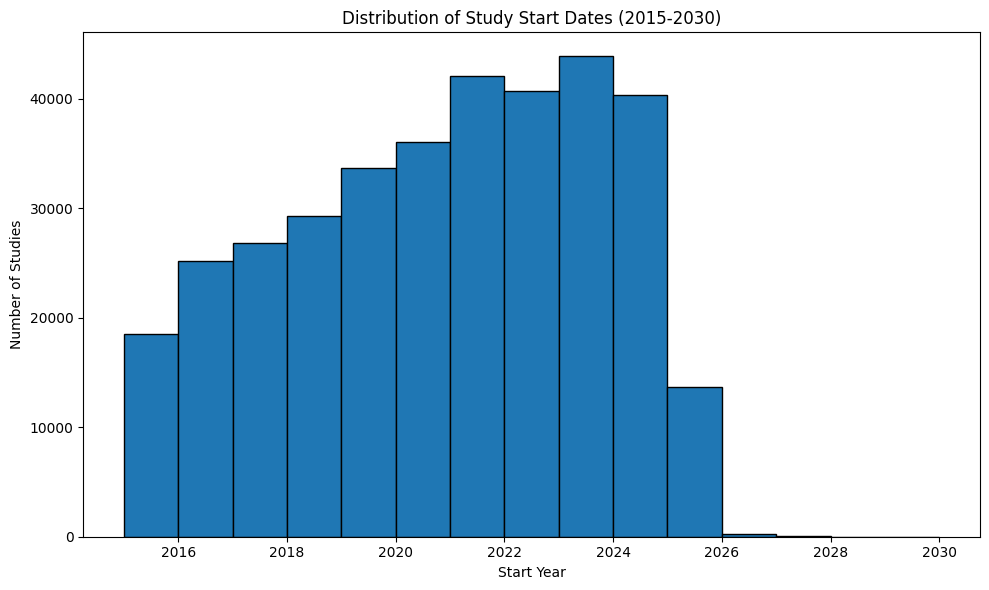

In [22]:
import matplotlib.pyplot as plt

# Convert the 'start_date' column to datetime, coerce errors to NaT
raw_df['start_date'] = pd.to_datetime(raw_df['start_date'], errors='coerce')

# Drop missing dates for plotting
start_dates = raw_df['start_date'].dropna()

# Plot histogram of start dates by year, from 2010 to 2030
plt.figure(figsize=(10,6))
plt.hist(
    start_dates.dt.year,
    bins=range(2015, 2031),  # 2015 to 2030 inclusive
    edgecolor='black'
)
plt.xlabel('Start Year')
plt.ylabel('Number of Studies')
plt.title('Distribution of Study Start Dates (2015-2030)')
plt.tight_layout()
plt.show()


### Pull all currently recruiting investigators

In [28]:
# --- notebook cell: extract recruiting investigators --------------------
from __future__ import annotations
from sqlalchemy import text
import pandas as pd
from datetime import date, timedelta

def recruiting_investigators(zip_prefix: str | None = None,
                             years_back: int = 5,
                             conn = engine) -> pd.DataFrame:
    cutoff = (date.today() - timedelta(days=365 * years_back)).isoformat()
    extra_zip = "AND f.zip LIKE :zip" if zip_prefix else ""
    params = {"cutoff": cutoff}
    if zip_prefix:
        params["zip"] = f"{zip_prefix}%"

    sql = text(f"""
        SELECT
            fi.name            AS investigator,
            fi.role,
            f.name             AS facility,
            f.city, f.state, f.zip,
            s.nct_id, s.start_date
        FROM   ctgov.facility_investigators fi
        JOIN   ctgov.facilities            f  ON f.id = fi.facility_id
        JOIN   ctgov.studies               s  ON s.nct_id = f.nct_id
        WHERE  f.country = 'United States'
          AND  f.status  IN ('Recruiting','Not yet recruiting')
          AND  s.start_date >= :cutoff
          {extra_zip}
        ORDER  BY lower(fi.name), s.nct_id;
    """)

    with conn.begin() as c:
        return pd.read_sql(sql, c, params=params)

df = recruiting_investigators(years_back=10)   # ~30‑40 k rows country‑wide
df.to_csv("recruiting_investigators.csv", index=False)
print("wrote", len(df), "rows")

wrote 0 rows
